
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


In [1]:
!nvidia-smi

Wed Mar 18 16:15:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Data Loading
We provide the code for data loading.

In [3]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


Specify the generator and the discriminator to get the following architectures:

```
 Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
```


```
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)
```

We recommend the use of leaky-relu for the hidden layers and tanh for the last layer of the generator. We let you chose the appropriate activation for the last layer of the discriminator. We also recommend using dropout(0.3) in the discriminator.


In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        
        #self.d0  = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=g_input_dim,  out_features=128*7*7, bias=True)
        self.inflat_shape = (-1, 128, 7, 7)
        self.b1 = nn.BatchNorm2d(128)
        self.up2 = nn.Upsample(scale_factor=(2, 2))
        self.c3  = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(5, 5), padding=2, bias=True)
        self.b2 = nn.BatchNorm2d(64)
        self.up4 = nn.Upsample(scale_factor=(2, 2))
        self.c5  = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(5, 5), padding=2, bias=True)
        
    # forward method
    def forward(self, x): 
        #x = self.d1(x)
        x = F.leaky_relu(self.fc1(x))
        x = x.view(self.inflat_shape)
        x = self.b1(x)
        x = self.up2(x)
        x = F.leaky_relu(self.c3(x))
        x = self.b2(x)
        x = self.up4(x)
        x = torch.tanh(self.c5(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.c1  = nn.Conv2d(in_channels=1,       out_channels=64,  kernel_size=(5, 5), stride=(2, 2), padding=2, bias=True)
        self.c2  = nn.Conv2d(in_channels=64,      out_channels=128, kernel_size=(5, 5), stride=(2, 2), padding=2, bias=True)
        self.fl3 = nn.Flatten()
        self.fc4 = nn.Linear(in_features=128*7*7, out_features=1,  bias=True)
        
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.c1(x))
        x = F.leaky_relu(self.c2(x))
        x = self.fl3(x)
        x = torch.sigmoid(self.fc4(x)) # (torch.tanh(self.fc4(x)) + 1) / 2
        return x

## We instantiate the networks

In [5]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


You can check if the architectures are correct.

In [6]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=6272, bias=True)
  (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up2): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (c3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up4): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (c5): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [7]:
D

Discriminator(
  (c1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (c2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fl3): Flatten()
  (fc4): Linear(in_features=6272, out_features=1, bias=True)
)

## Training configuration
Chose the discriminator loss.

In [0]:
# loss
#criterion = nn.NLLLoss()
criterion = nn.BCELoss()

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

Now, let's code the discriminator update

In [0]:
def D_train(x): # x is a batch composed of images
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # we use 1 for real and 0 for fake
    # train discriminator on real
    x_real = x.view(-1, 1, 28, 28)
    y_real = Variable(torch.ones(bs).to(device))
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake = G(z)
    y_fake = Variable(torch.zeros(bs).to(device))
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

Now, let's code the generator update

In [0]:
def G_train():
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs).to(device))
    G_output = G(z) 
    D_output = D(G_output)
    G_loss =  criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

We provide this visualization function.

In [0]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))



Finally, this is the main loop:

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/20]: loss_d: 0.881, loss_g: 1.759
(100, 1, 28, 28)


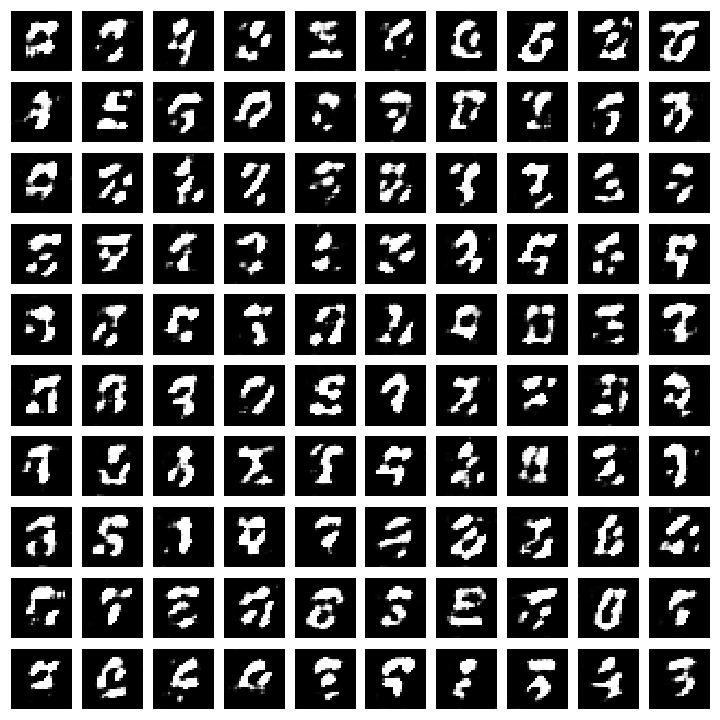

[2/20]: loss_d: 0.907, loss_g: 1.592
(100, 1, 28, 28)


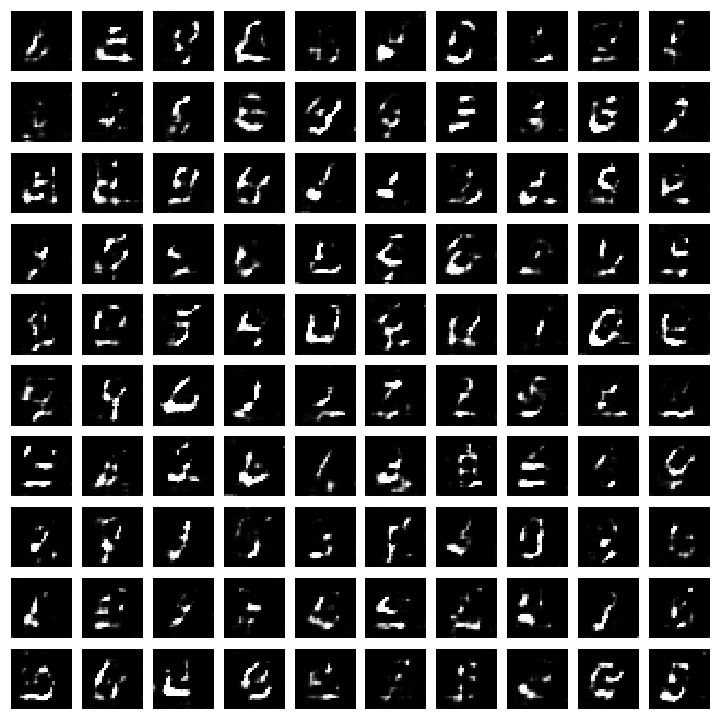

[3/20]: loss_d: 0.940, loss_g: 1.604
(100, 1, 28, 28)


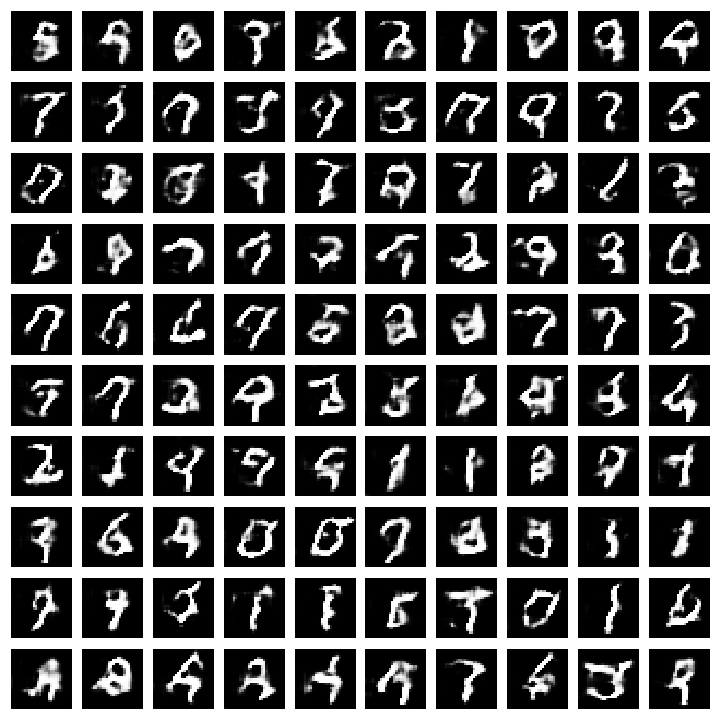

[4/20]: loss_d: 1.031, loss_g: 1.294
(100, 1, 28, 28)


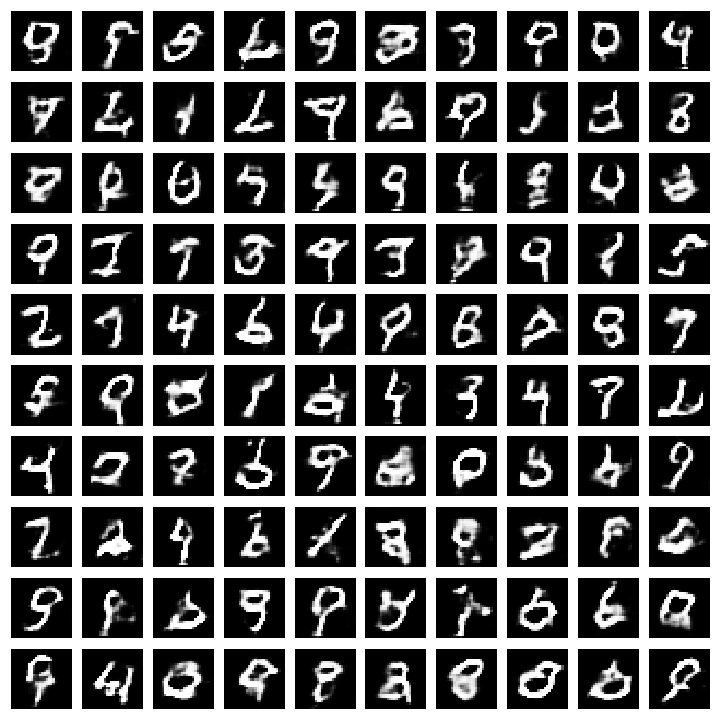

[5/20]: loss_d: 1.050, loss_g: 1.191
(100, 1, 28, 28)


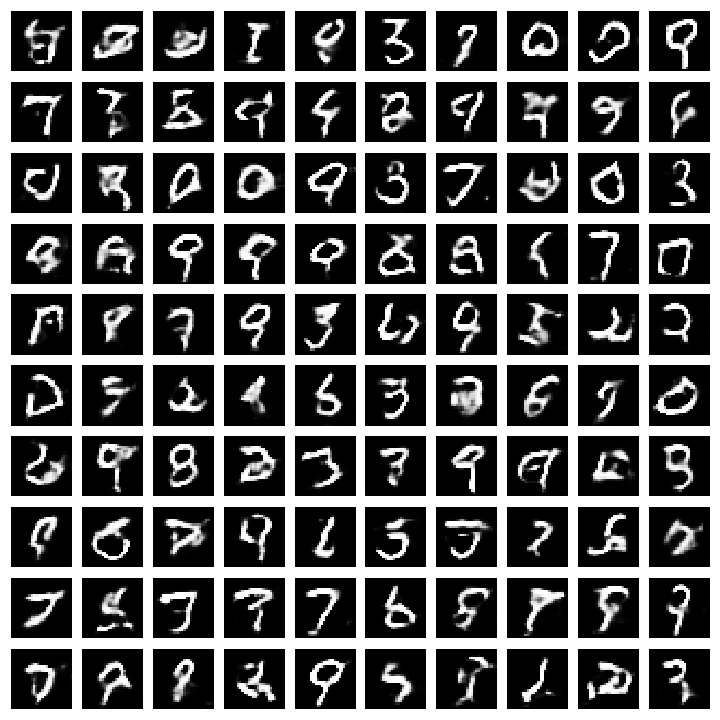

[6/20]: loss_d: 1.026, loss_g: 1.221
(100, 1, 28, 28)


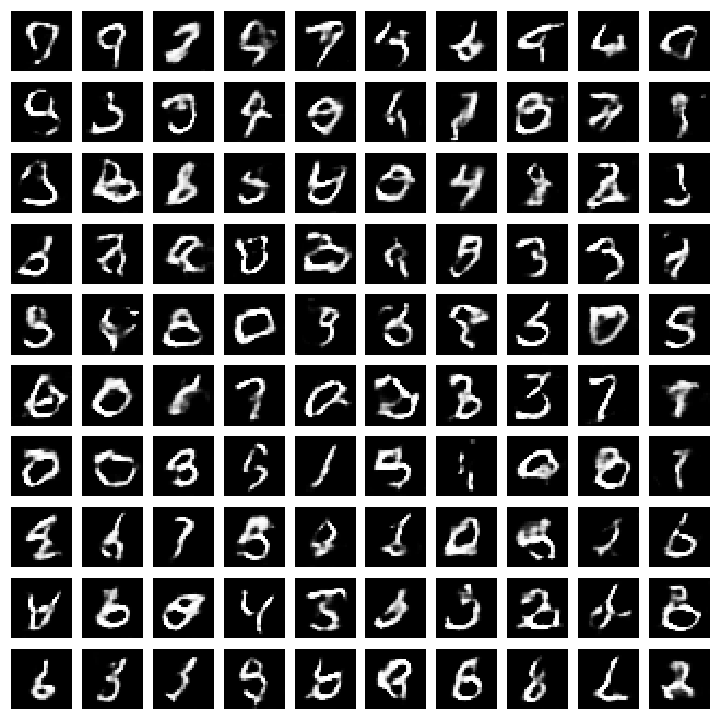

[7/20]: loss_d: 0.972, loss_g: 1.254
(100, 1, 28, 28)


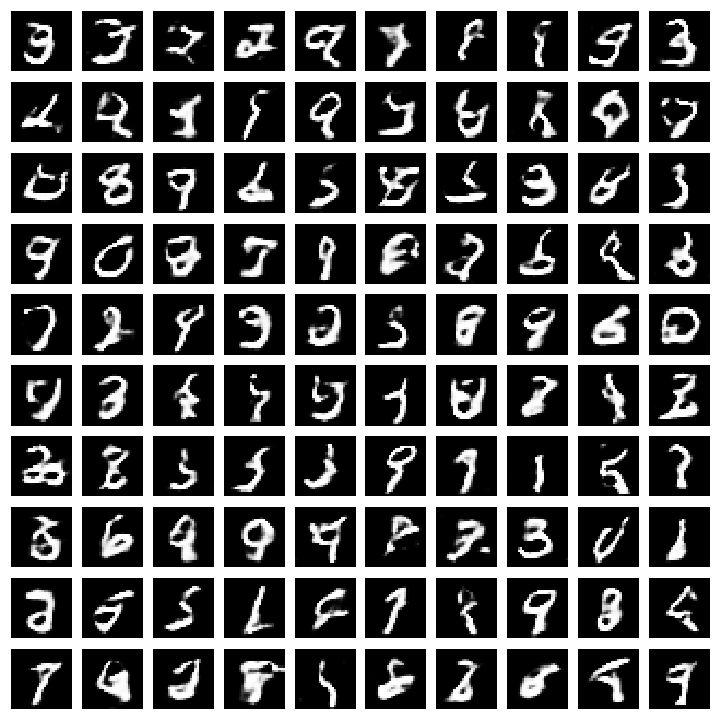

[8/20]: loss_d: 0.937, loss_g: 1.365
(100, 1, 28, 28)


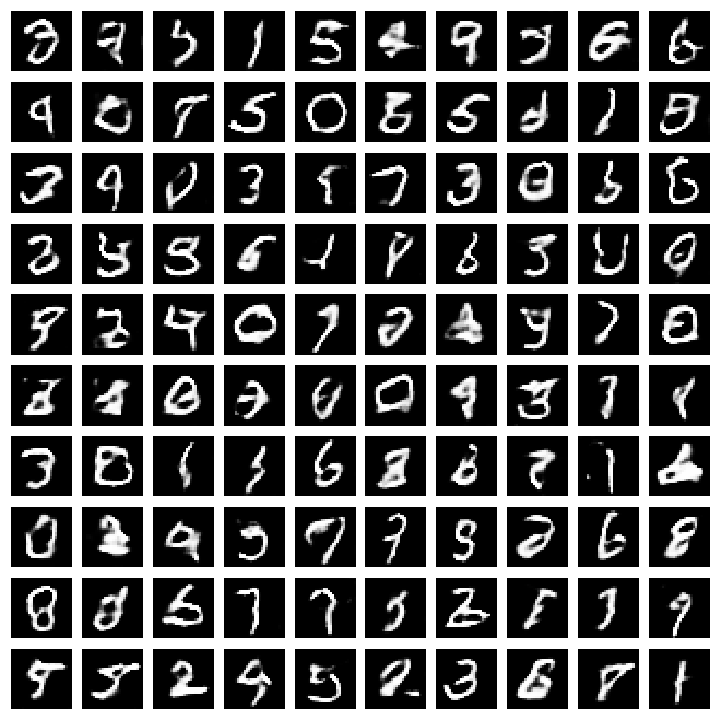

[9/20]: loss_d: 0.899, loss_g: 1.471
(100, 1, 28, 28)


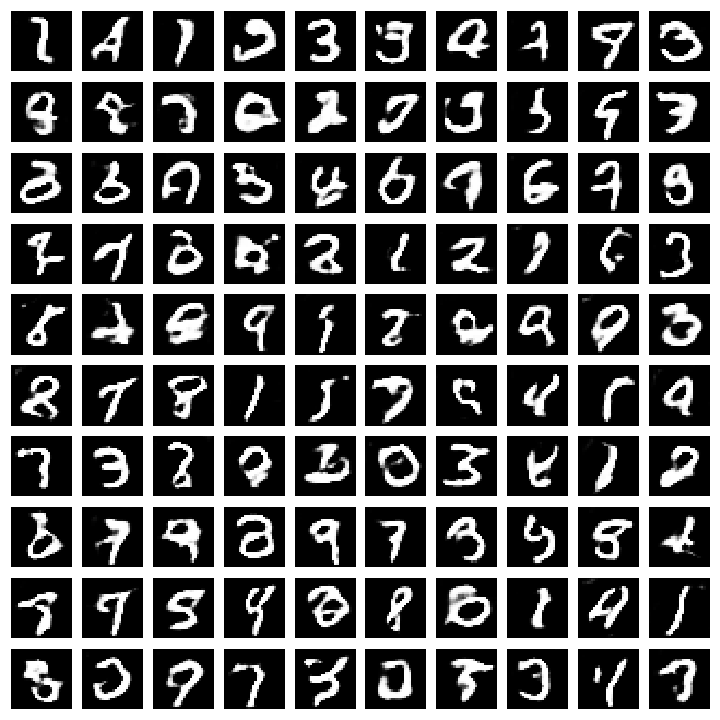

[10/20]: loss_d: 0.880, loss_g: 1.437
(100, 1, 28, 28)


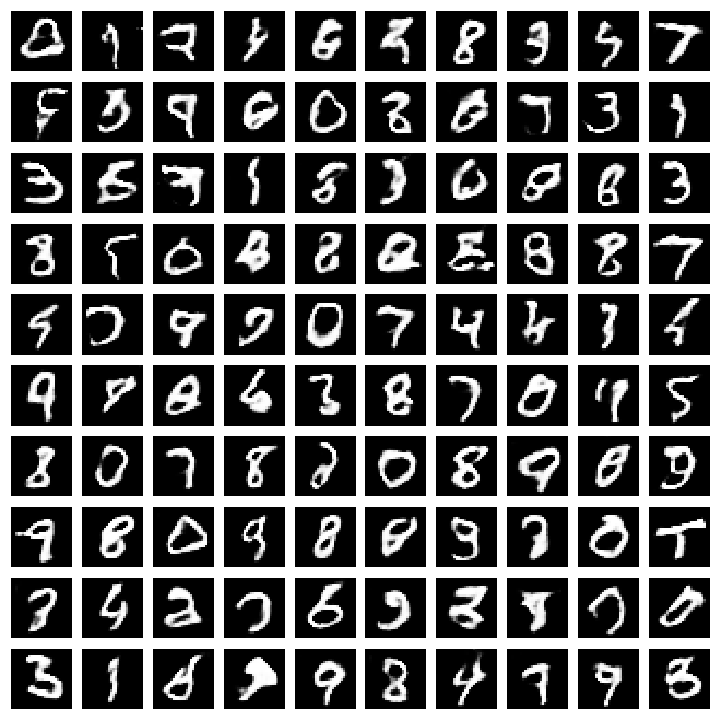

[11/20]: loss_d: 0.841, loss_g: 1.478
(100, 1, 28, 28)


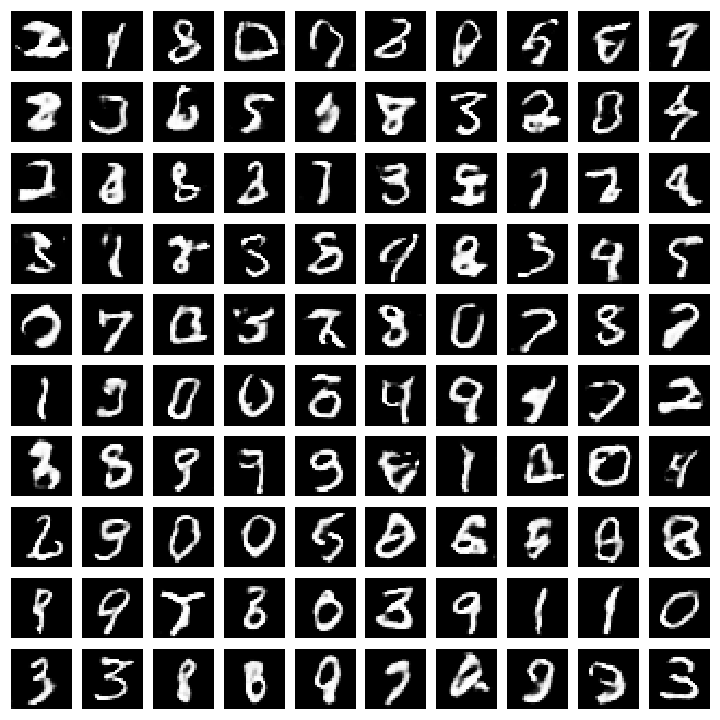

[12/20]: loss_d: 0.823, loss_g: 1.693
(100, 1, 28, 28)


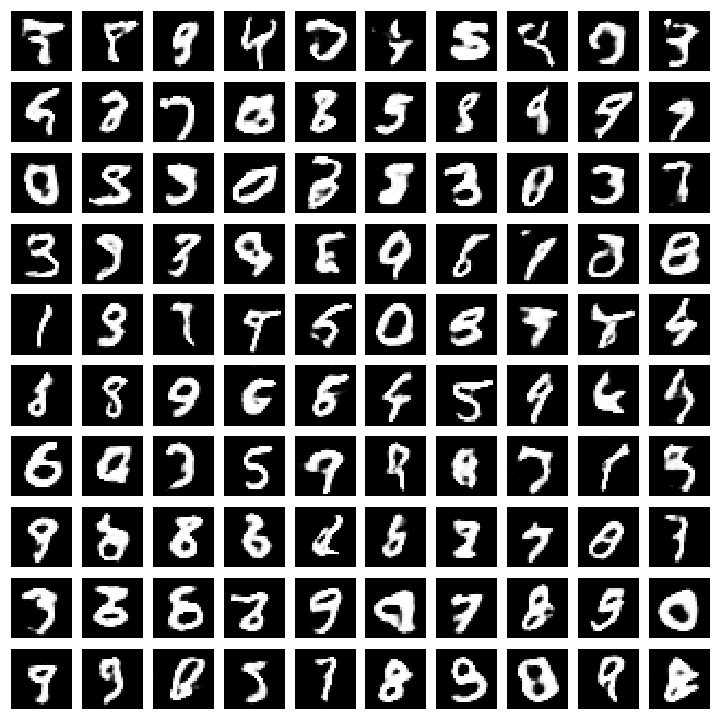

[13/20]: loss_d: 0.817, loss_g: 1.550
(100, 1, 28, 28)


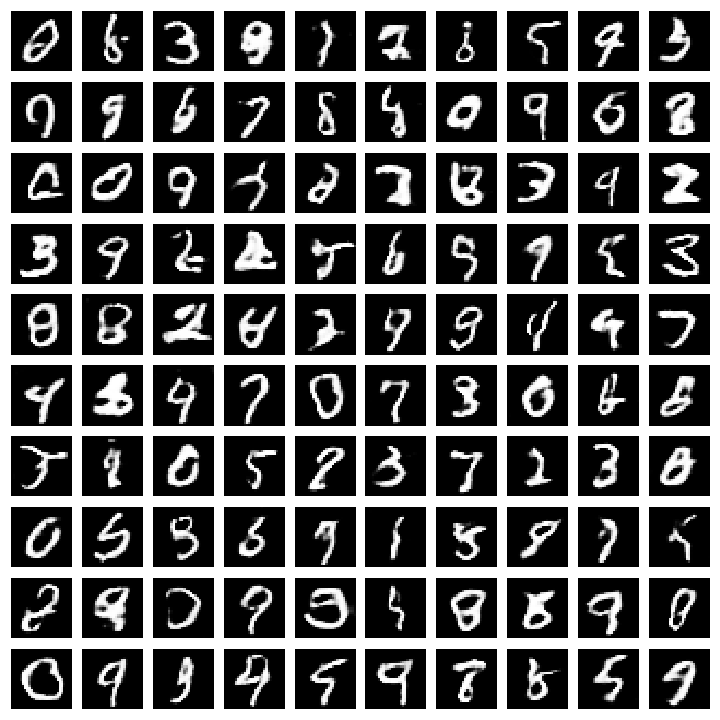

[14/20]: loss_d: 0.787, loss_g: 1.603
(100, 1, 28, 28)


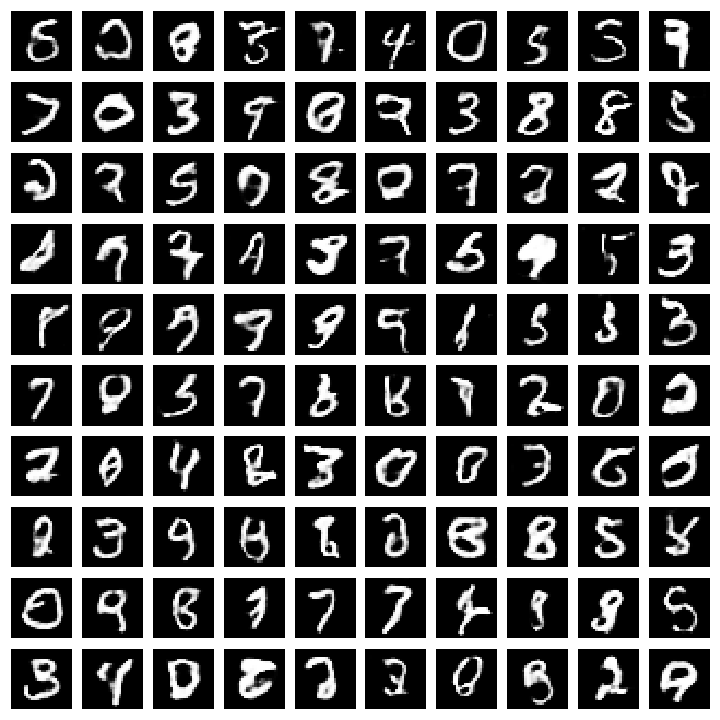

[15/20]: loss_d: 0.773, loss_g: 1.670
(100, 1, 28, 28)


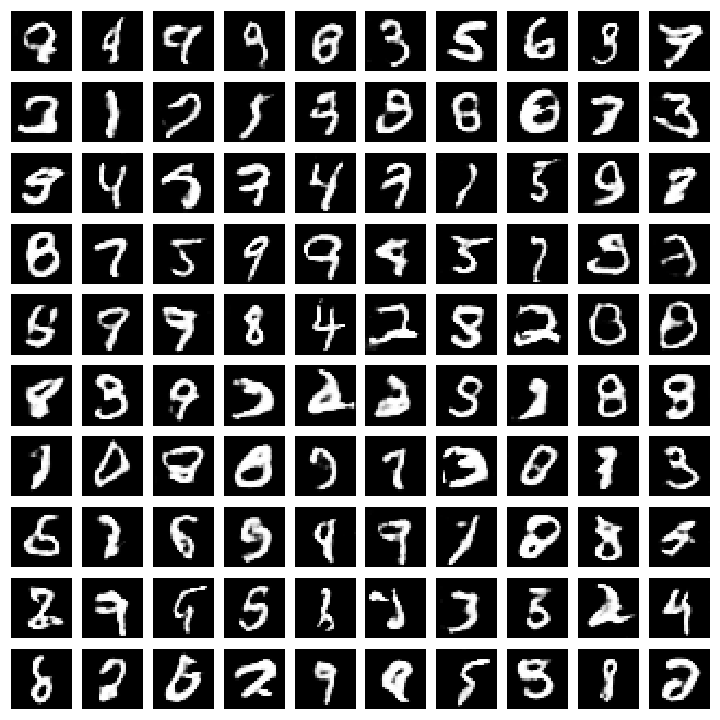

[16/20]: loss_d: 0.765, loss_g: 1.731
(100, 1, 28, 28)


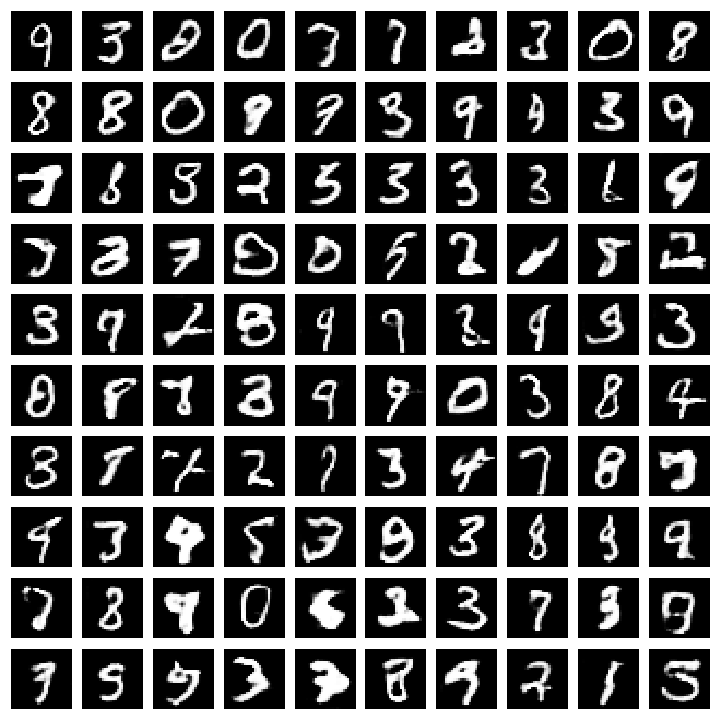

[17/20]: loss_d: 0.752, loss_g: 1.697
(100, 1, 28, 28)


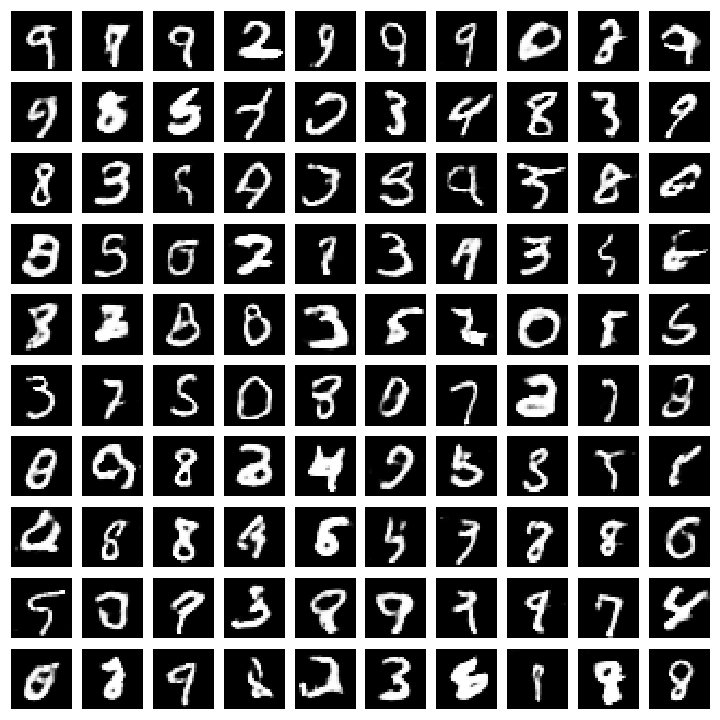

[18/20]: loss_d: 0.750, loss_g: 1.735
(100, 1, 28, 28)


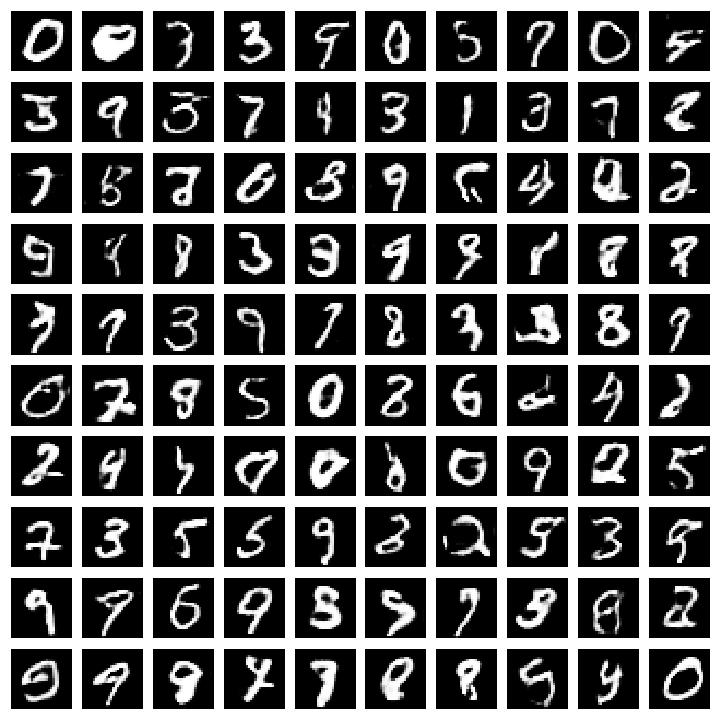

[19/20]: loss_d: 0.754, loss_g: 1.785
(100, 1, 28, 28)


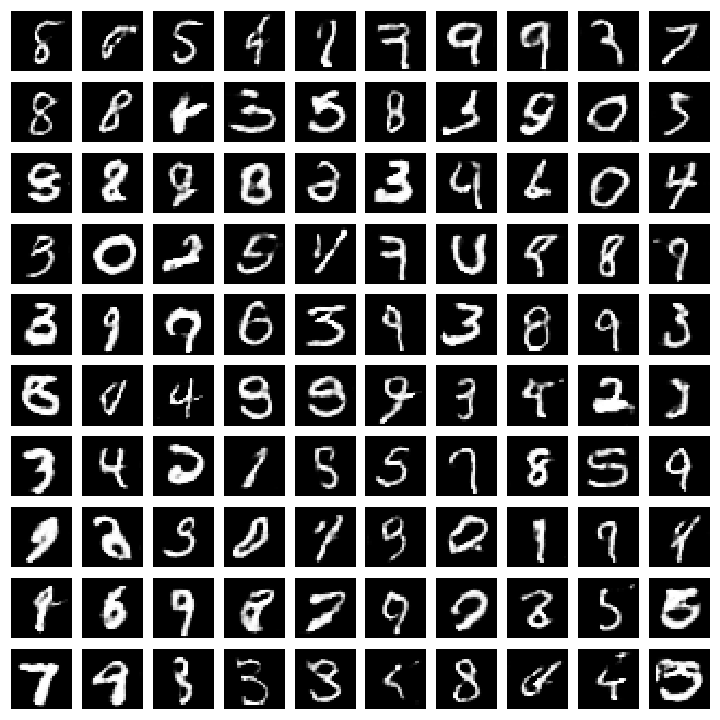

[20/20]: loss_d: 0.748, loss_g: 1.742
(100, 1, 28, 28)


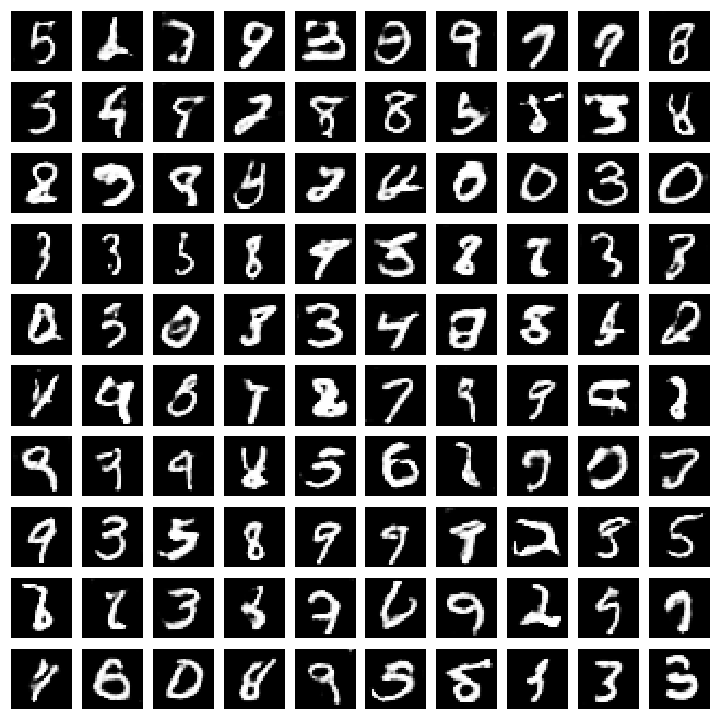

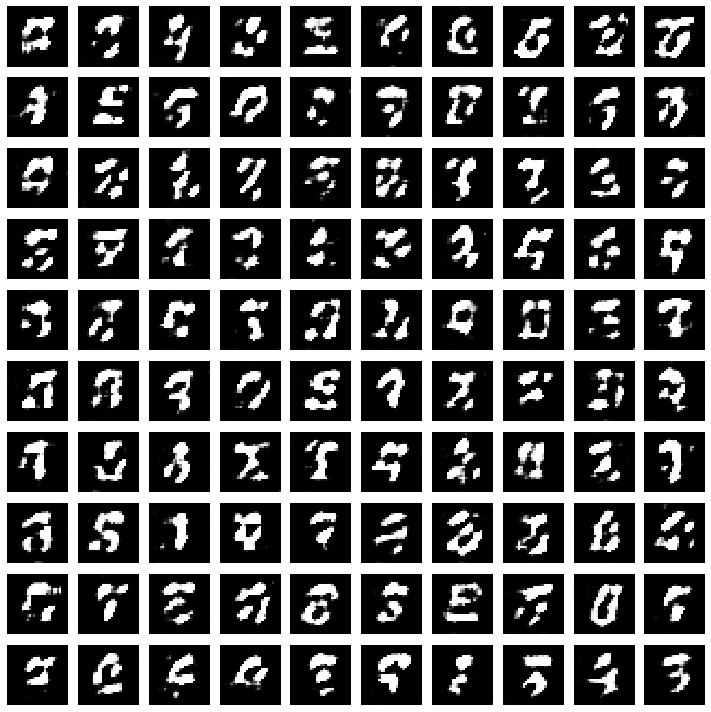

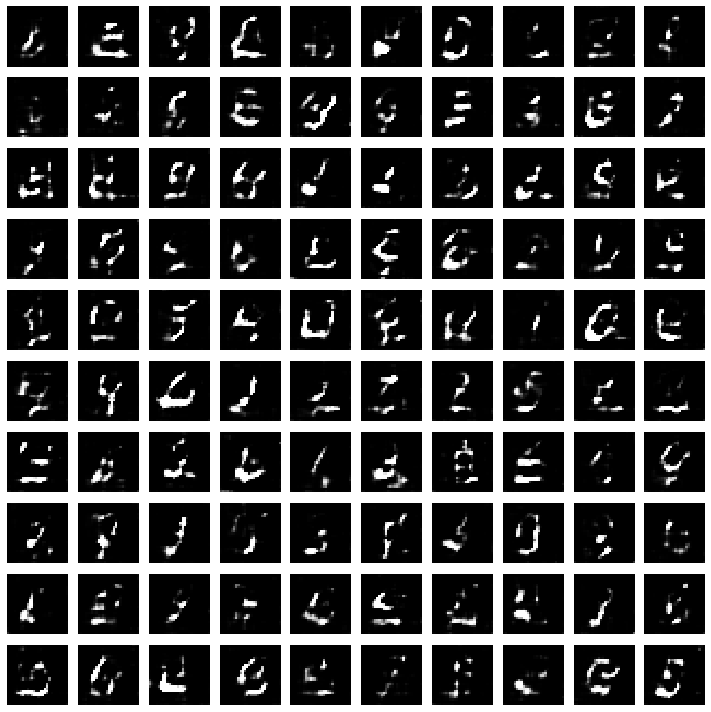

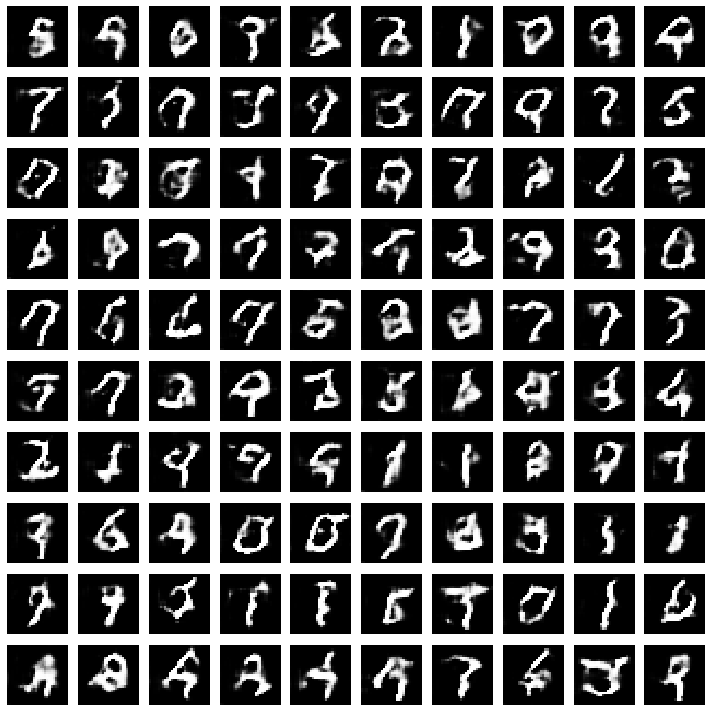

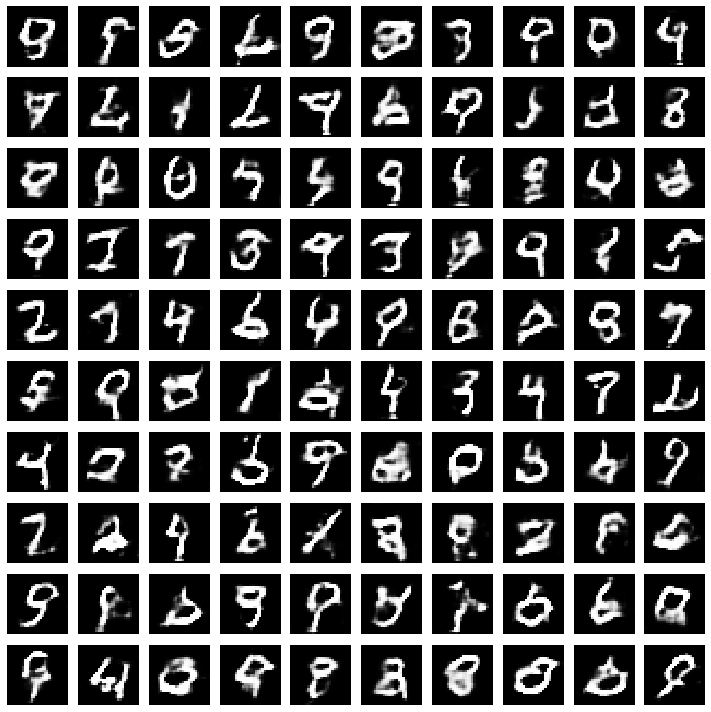

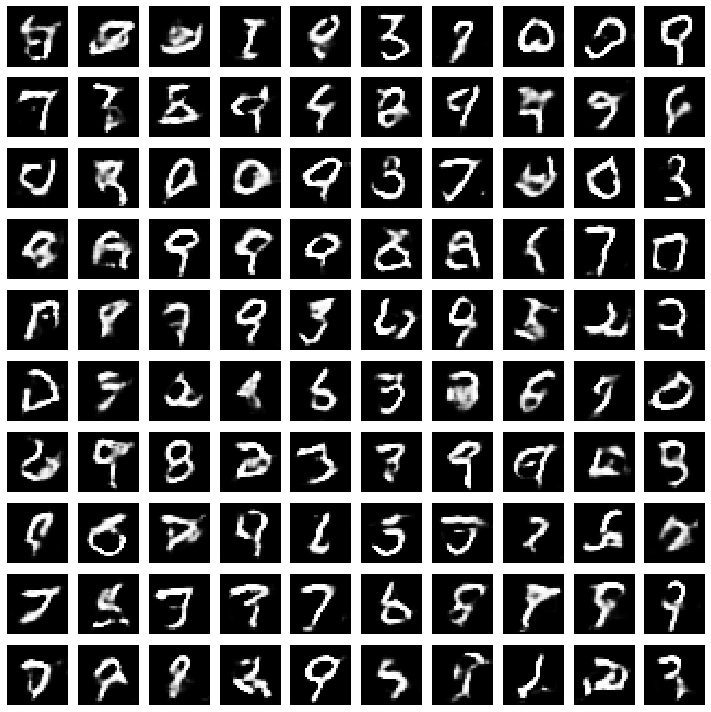

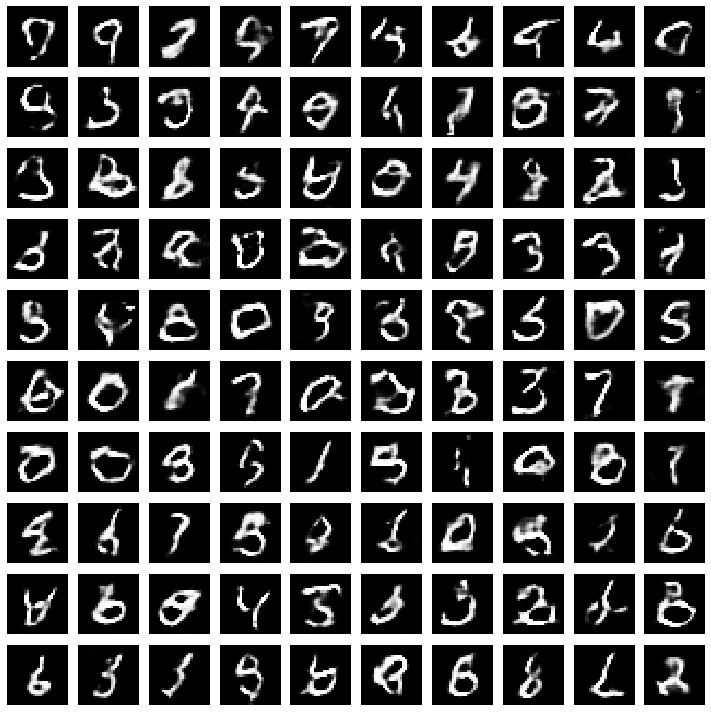

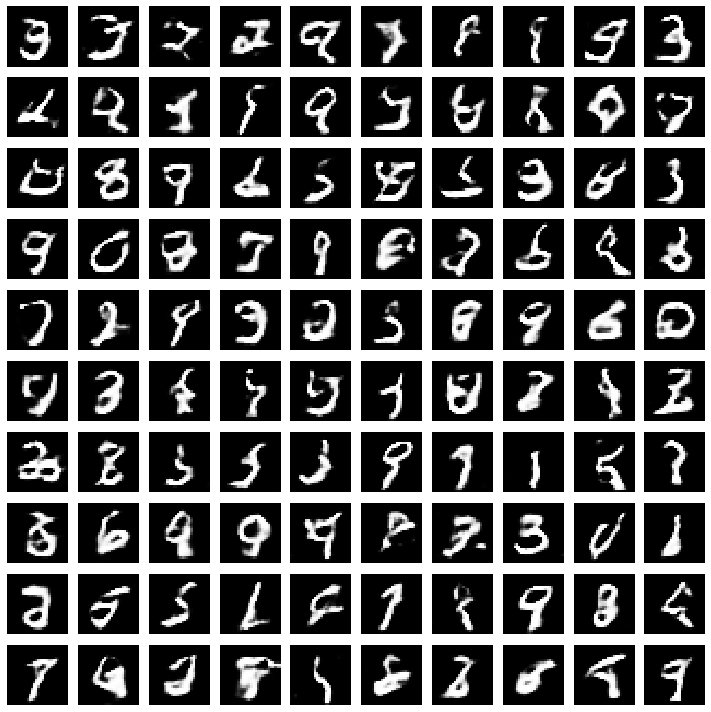

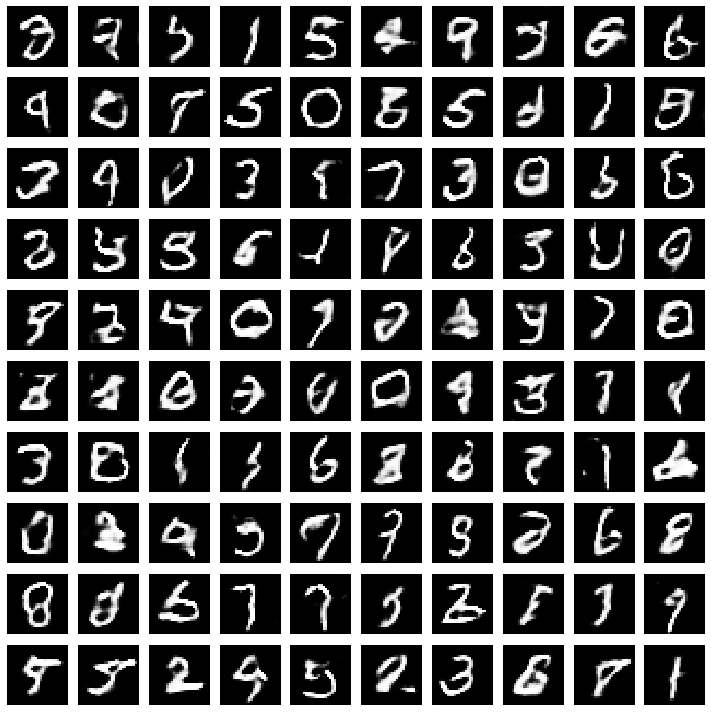

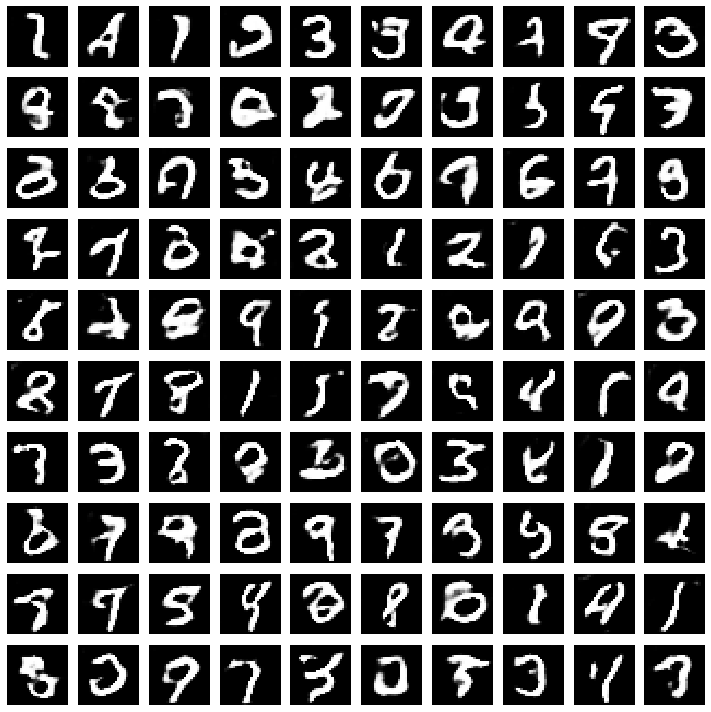

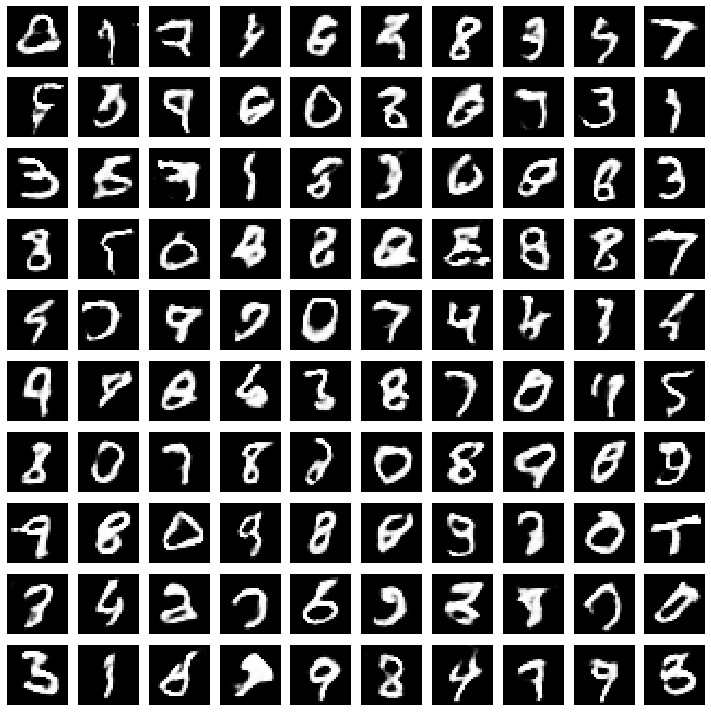

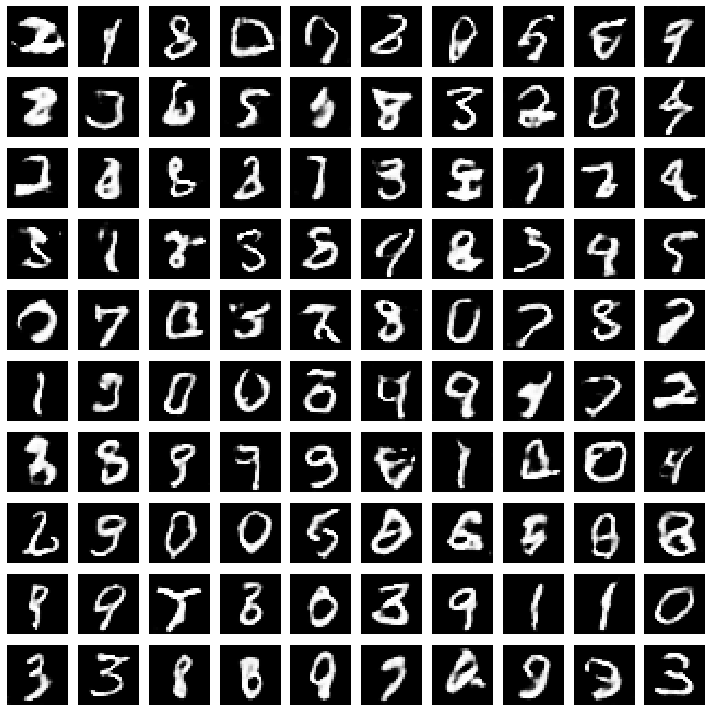

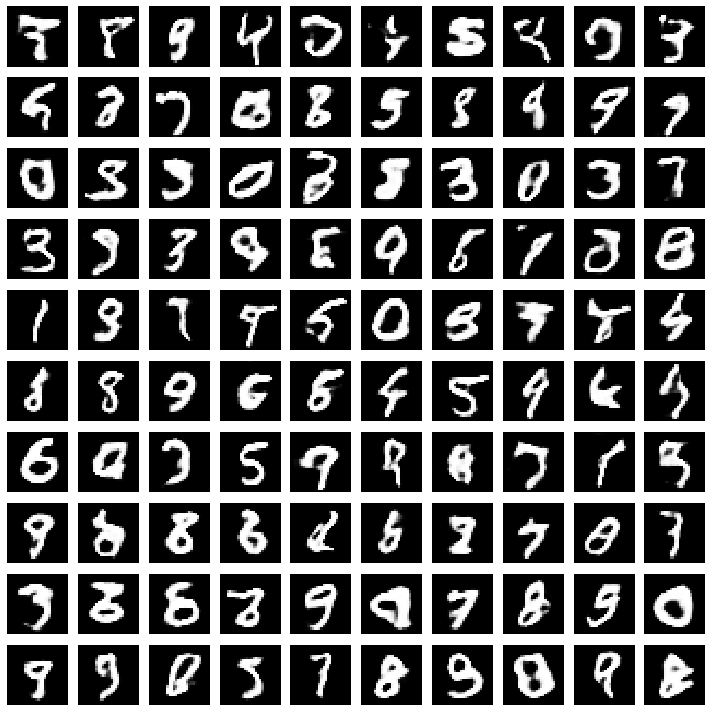

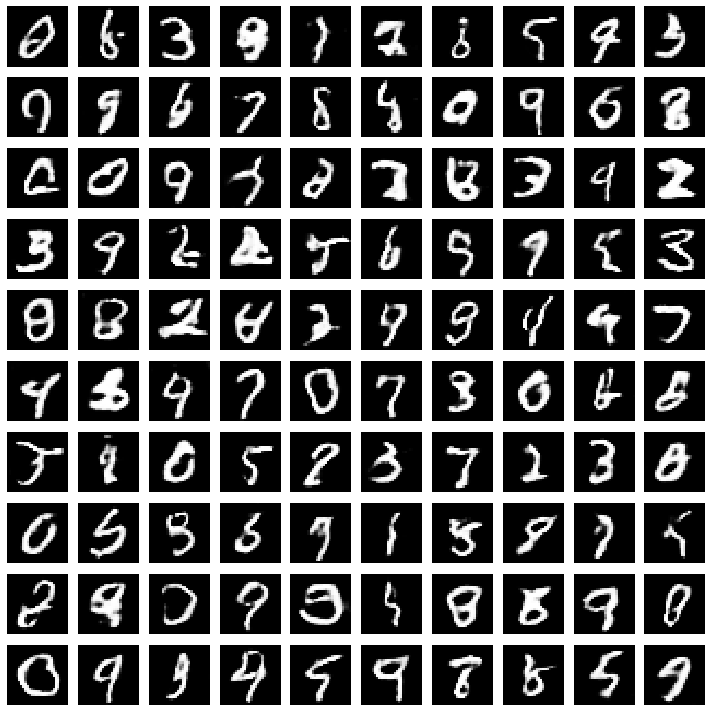

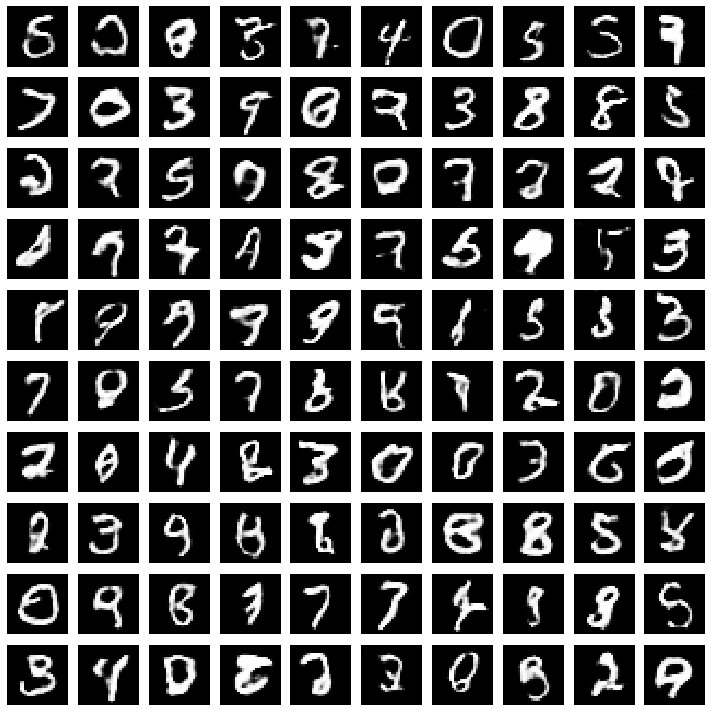

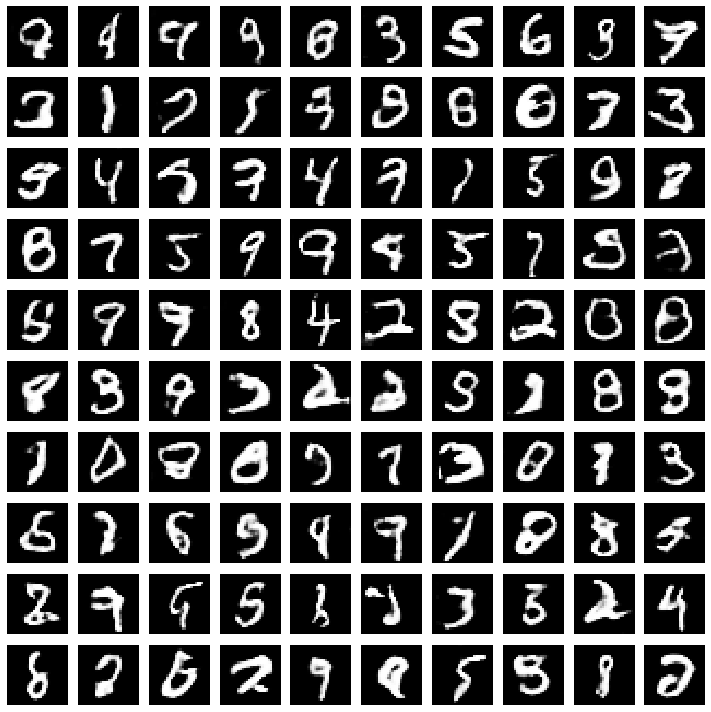

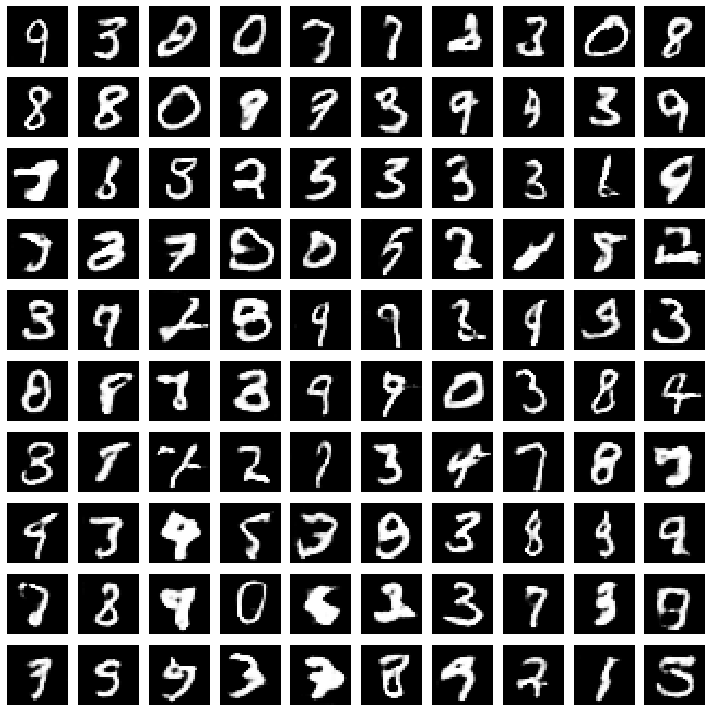

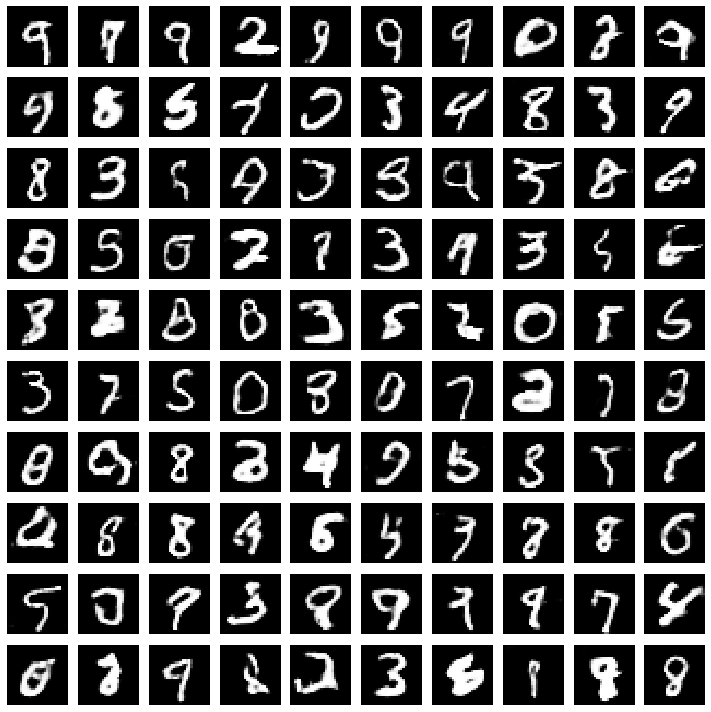

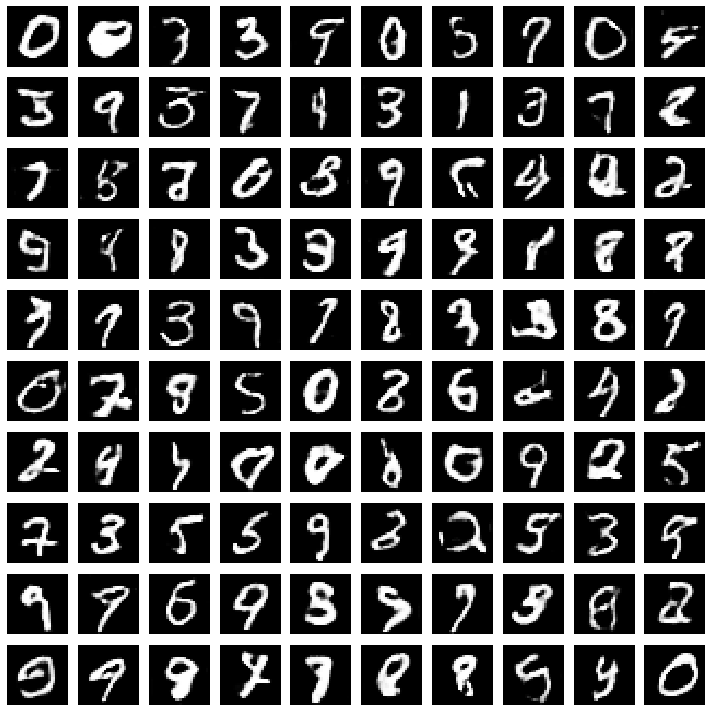

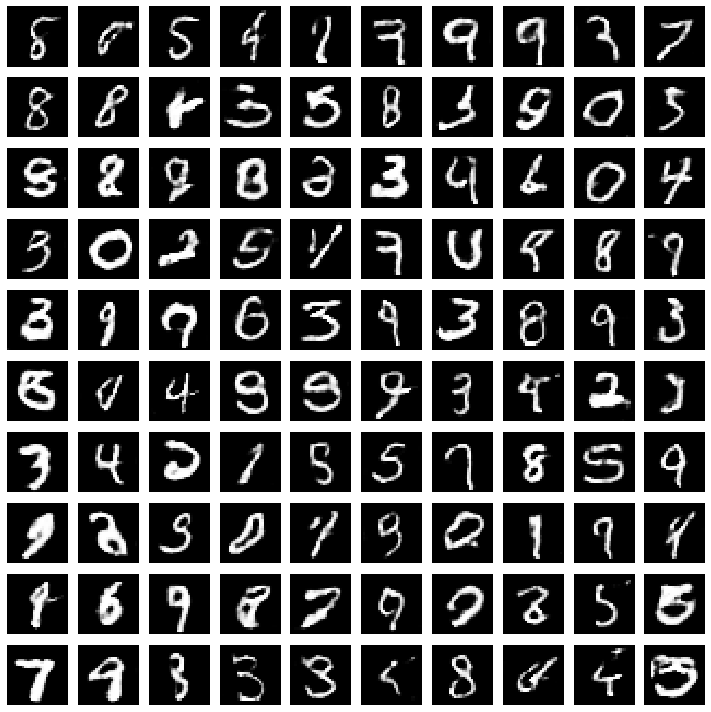

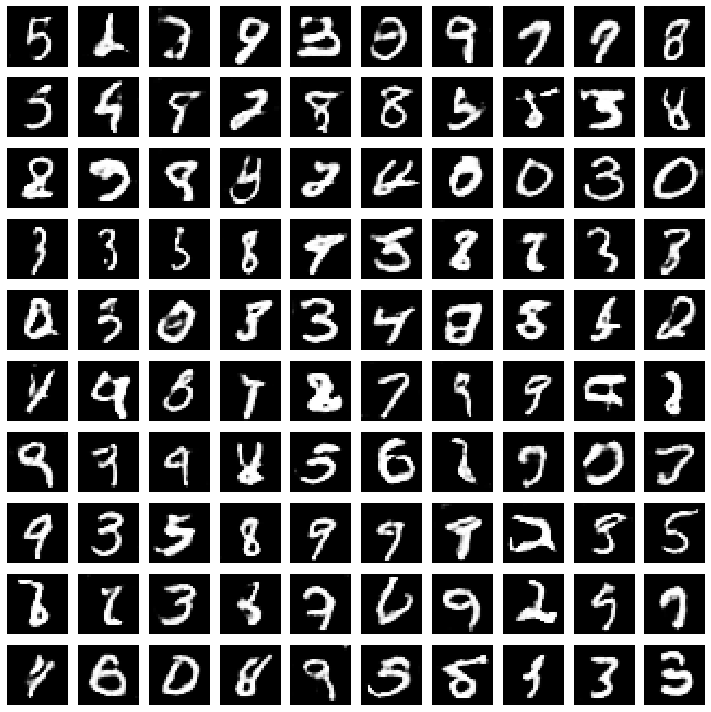

In [12]:
n_epoch = 20
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        loss_D = D_train(x)
        D_losses.append(loss_D)
        loss_G = G_train()
        G_losses.append(loss_G)

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    

    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G(test_z)
        plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))

DCGAN

Save a copy of your colab. Now, we will implement a version of GAN that uses convolutions: DCGAN. You can find the paper [here](https://arxiv.org/abs/1511.06434). The main idea of DCGAN is to use convolutions in the generator and discriminator in order to get images that are more spacially consistent. Replace your naive generator and decoder by the DCGAN architectures. This is slower to train but by looking at the images after one epoch, you can already draw an interesting conclusion. The architecture is not clearly specified for mnist. You can use the following generator (use leakyRelu):


*   Dense(128x7x7) 
*   UpSampling2D
*   Conv2D(64, kernel_size=(5, 5)
*   UpSampling2D
*   Conv2D(1, kernel_size=(5, 5) 

Use a tanh activation at the end.

For the discriminator:


* Conv2D(64, kernel_size=(5, 5), strides=(2, 2)
* Conv2D(128, kernel_size=(5, 5), strides=(2, 2)
* Dense(1, activation='sigmoid'))
